# Task 01: Introduction to Pytorch

## Introduction

The goal of this task is to get us thinking not just about training models, but about our *training pipelines*.

A neural network is a function, $f$, that accepts in data inputs, $\boldsymbol{X}$, and weights, $\boldsymbol{\Theta}$ that produces labels $\boldsymbol{\hat{y}}$,

$$
\boldsymbol{\hat{y}} = f(\Theta; \boldsymbol{X}).
$$

Meanwhile, a neural network training process, is itself a function, $g$, which accepts as input a dataset $x$, and for supervised algorithms a set of targets $y$, along with a set of parameters $\boldsymbol{\Omega}$ which define how the process is performed, and produces as output the weights of a neural network, $\boldsymbol{\Theta}$,

$$
\Theta = g(\boldsymbol{\Omega}; \boldsymbol{X}, \boldsymbol{y}).
$$

It is helpful to think of the training function, $g$, as a pipeline, composed of several training steps, which can include preprocessing, post processing, etc.

$$
g = g_N \circ\ \cdots\ \circ g_1.
$$

For example, $g_1$ might be a preprocessing step, then $g_2$ might be a training step, and $g_3$ might be a pruning step in a basic pipeline where data $(\boldsymbol{X}, \boldsymbol{y})$ goes in and weights $\boldsymbol{\Theta}$ come out.

We will learn to think of the training process this way by modifying some example code for a basic MNIST classification task. We begin with some imports.

In [5]:
# %load_ext autoreload
# %autoreload 2
# %matplotlib widget

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
from dataclasses import dataclass


## Task 01 - Part 1

Your first task is to:

* Add layer definitions to the following neural network class
* Define the forward pass

You can find starting architectures online. It is important to know there is no known theory to identify a best architecture *before* starting the problem. Trial and error (by iterative training and testing) is the only way to prove or disprove the utility of an architecture.

That said, recall some intuition about the way linear and nonlinear transforms work. We know we need a chain of both to have any hope of solving this problem. We also know that we need some depth, and cannot solve this problem by width alone.


In [15]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Define layers for MNIST classification
        self.fc1 = nn.Linear(28 * 28, 128) #   # First fully connected layer (input to hidden layer)
        self.fc2 = nn.Linear(128, 64)  # Second fully connected layer (hidden layer to another hidden layer)
        self.fc3 = nn.Linear(64, 10)  # Output layer (10 classes for MNIST)
        self.test_errors = []
    def forward(self, x):
        # Flatten the input image from 28x28 to a vector of size 784
        # Here we define what we do with layers
        # We can add dropouts for overfittings. 
        # Dropout randomly sets a fraction of input units to 0 at each update during training time,
        # which helps prevent overfitting.
        # x = F.dropout(x, training=self.training)  # Apply dropout during training [It will randomly set some values to 0]
        
        # Flatten the input image from 28x28 to a vector of size 784 (which is the input to the first fully connected layer)
        # Here we transform the input data from a 2D tensor (image) to a 1D tensor (vector)
        # This is because the fully connected layer expects a 1D input.
        # The view function reshapes the tensor to have a new shape. 28*28 is the total number of pixels in an image. 784 is the number of neurons in the first fully connected layer. 1 is the batch size, which is not needed for this case.
        x = x.view(-1, 28 * 28)
        
        # Apply ReLU activation after each layer
        x = F.relu(self.fc1(x))  # First hidden layer # Relu is a function 
        x = F.relu(self.fc2(x))  # Second hidden layer
        
        # Output layer with log-softmax for classification [It will give me prob for classes for all the 10 classes]
        # Then we get the argmax which will give me the max probability of the 10 classes
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)  # Return log probabilities [Here I got the max prob]


def run_training_epoch(training_params, model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % training_params.log_interval == 0:
            print(
                "Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                    epoch,
                    batch_idx * len(data),
                    len(train_loader.dataset),
                    100.0 * batch_idx / len(train_loader),
                    loss.item(),
                )
            )
            if training_params.dry_run:
                break


def predict(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction="sum").item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    
    # Ensure that test_loss is appended to the model's test_errors list
    self.test_errors.append(test_loss)

    print(
        "\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n".format(
            test_loss,
            correct,
            len(test_loader.dataset),
            100.0 * correct / len(test_loader.dataset),
        )
    )

## Helper Code: Training Pipeline

For this assignment, the training pipeline is defined for you. Notice the similarities to the mathematical description of a trainer we saw above.

In [16]:
@dataclass
class TrainingParameters:
    """Training parameters for a simple neural network trainer."""

    batch_size: int = 64
    test_batch_size: int = 1000
    epochs: int = 14
    lr: float = 1.0
    gamma: float = 0.7
    normalizer_mean = 0.1307
    normalizer_std = 0.3081
    no_cuda: bool = True  # Enable or disable CUDA
    no_mps: bool = True  # Enable or disable GPU on MacOS
    dry_run: bool = False
    seed: int = 1
    log_interval: int = 10
    save_model: bool = True


def configure_training_device(training_params):
    use_cuda = not training_params.no_cuda and torch.cuda.is_available()
    use_mps = not training_params.no_mps and torch.backends.mps.is_available()

    torch.manual_seed(training_params.seed)

    if use_cuda:
        device = torch.device("cuda")
    elif use_mps:
        device = torch.device("mps")
    else:
        device = torch.device("cpu")

    train_kwargs = {"batch_size": training_params.batch_size}
    test_kwargs = {"batch_size": training_params.test_batch_size}

    if use_cuda:
        cuda_kwargs = {"num_workers": 1, "pin_memory": True, "shuffle": True}
        train_kwargs.update(cuda_kwargs)
        test_kwargs.update(cuda_kwargs)
    return device, train_kwargs, test_kwargs


def build_preprocessing_transform(training_params):
    transform = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize(
                (training_params.normalizer_mean,),
                (training_params.normalizer_std,),
            ),
        ]
    )

    return transform


def build_data_loaders(train_kwargs, test_kwargs, transform):
    dataset1 = datasets.MNIST(
        "../data", train=True, download=True, transform=transform
    )
    dataset2 = datasets.MNIST("../data", train=False, transform=transform)

    train_loader = torch.utils.data.DataLoader(dataset1, **train_kwargs)
    test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)
    return train_loader, test_loader


def train(training_params, device, train_loader, test_loader):
    model = Net().to(device)
    optimizer = optim.Adadelta(model.parameters(), lr=training_params.lr)
    scheduler = StepLR(optimizer, step_size=1, gamma=training_params.gamma)

    for epoch in range(1, training_params.epochs + 1):
        run_training_epoch(
            training_params, model, device, train_loader, optimizer, epoch
        )
        predict(model, device, test_loader)
        scheduler.step()

        if training_params.save_model:
            torch.save(model.state_dict(), "mnist_cnn.pt")

## Example: Execute a Training Pipeline

With our training steps defined in modular fashion, we can easily define and execute a training pipeline.

In [17]:
def execute_training_pipeline():
    training_params = TrainingParameters(epochs=1, dry_run=True)
    device, train_kwargs, test_kwargs = configure_training_device(
        training_params
    )
    transform = build_preprocessing_transform(training_params)
    train_loader, test_loader = build_data_loaders(
        train_kwargs, test_kwargs, transform
    )
    train(training_params, device, train_loader, test_loader)


execute_training_pipeline()

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.304324


NameError: name 'self' is not defined

# Task 01 - Part 2: Explore Width

Using the example above, define a network with a single hidden layer.

Modify the trainer to store the train and test errors in a numpy vector.

Create a for loop over to iterate through a few different amounts of hidden neurons and train until convergence (when the error stops decreasing) each time.

Save the minimum error achieved and plot it with respect to the number of hidden nodes.

(It should be hard to get good convergence here - this is part of the exercise.)

In [9]:
# Your code here
import numpy as np

class NetWithErrors(Net):
    def __init__(self):
        super(NetWithErrors, self).__init__()
        self.train_errors = []
        self.test_errors = []

    def run_training_epoch(self, training_params, model, device, train_loader, optimizer, epoch):
        model.train()
        epoch_loss = 0
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()  # Accumulate batch loss for the epoch

            if batch_idx % training_params.log_interval == 0:
                print(
                    "Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                        epoch,
                        batch_idx * len(data),
                        len(train_loader.dataset),
                        100.0 * batch_idx / len(train_loader),
                        loss.item(),
                    )
                )
                if training_params.dry_run:
                    break

        # Store the average training loss for this epoch
        self.train_errors.append(epoch_loss / len(train_loader.dataset))

    def predict(model, device, test_loader):
        model.eval()
        test_loss = 0
        correct = 0
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                test_loss += F.nll_loss(output, target, reduction="sum").item()  # sum up batch loss
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()

        test_loss /= len(test_loader.dataset)
        
        # Ensure this appends the test loss
        model.test_errors.append(test_loss)

        print(
            "\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n".format(
                test_loss,
                correct,
                len(test_loader.dataset),
                100.0 * correct / len(test_loader.dataset),
            )
        )
# When initializing the model, use the new class NetWithErrors
model_with_errors = NetWithErrors()

# The rest of the training pipeline will remain the same,
# and you can access the errors after training:
# e.g., model_with_errors.train_errors and model_with_errors.test_errors


Training with 16 hidden neurons
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.291744
Train Epoch: 1 [640/60000 (1%)]	Loss: 1.611259
Train Epoch: 1 [1280/60000 (2%)]	Loss: 1.320696
Train Epoch: 1 [1920/60000 (3%)]	Loss: 0.788864
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.476619
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.495227
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.281666
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.349652
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.738747
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.273978
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.261302
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.293486
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.336203
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.250630
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.281069
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.197109
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.490305
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.166250
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.586521
Train Epoch: 1 [12160/60000 (20%)]	Loss: 0.322

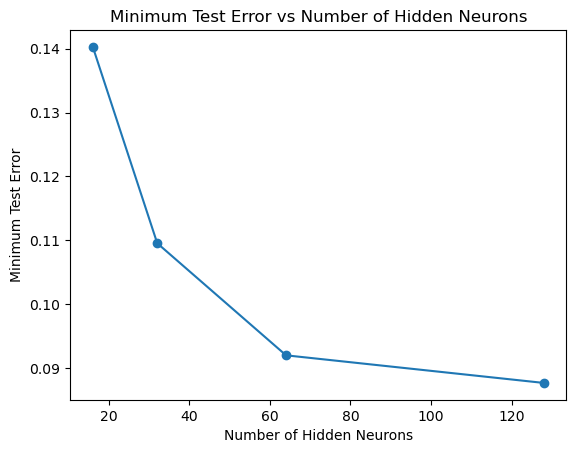

In [10]:
import matplotlib.pyplot as plt
class NetVariableHiddenLayers(Net):
    def __init__(self, hidden_neurons):
        super(NetVariableHiddenLayers, self).__init__()
        self.fc1 = nn.Linear(28 * 28, hidden_neurons)
        self.fc2 = nn.Linear(hidden_neurons, 64)
        self.fc3 = nn.Linear(64, 10)
        self.train_errors = []
        self.test_errors = []  # This initializes the list

        
# Now use the external `run_training_epoch` and `predict` functions as before
def train_until_convergence(training_params, hidden_neurons_list):
    min_errors = []
    
    for hidden_neurons in hidden_neurons_list:
        print(f"\nTraining with {hidden_neurons} hidden neurons")
        model = NetVariableHiddenLayers(hidden_neurons).to(device)
        optimizer = optim.Adadelta(model.parameters(), lr=training_params.lr)
        scheduler = StepLR(optimizer, step_size=1, gamma=training_params.gamma)

        prev_test_loss = float('inf')  # Initialize to infinity
        for epoch in range(1, training_params.epochs + 1):
            run_training_epoch(training_params, model, device, train_loader, optimizer, epoch)
            predict(model, device, test_loader)
            
            # Debugging: print the contents of test_errors
            print(f"Epoch {epoch}: model.test_errors = {model.test_errors}")
            
            # Check if the list is still empty
            if len(model.test_errors) == 0:
                raise RuntimeError("model.test_errors is empty after calling predict().")

            current_test_loss = model.test_errors[-1]

            # Stop training if the error stops decreasing (convergence condition)
            if abs(prev_test_loss - current_test_loss) < 1e-2:
                print(f"Convergence reached at epoch {epoch} for {hidden_neurons} neurons.")
                break
            prev_test_loss = current_test_loss

            scheduler.step()

        # Store the minimum error achieved for this number of neurons
        min_errors.append(min(model.test_errors))
    
    return hidden_neurons_list, min_errors
# Plotting function
def plot_errors(hidden_neurons_list, min_errors):
    plt.figure()
    plt.plot(hidden_neurons_list, min_errors, marker='o')
    plt.xlabel("Number of Hidden Neurons")
    plt.ylabel("Minimum Test Error")
    plt.title("Minimum Test Error vs Number of Hidden Neurons")
    plt.show()

# Example of hidden neuron list to try (you can change these values)
hidden_neurons_list = [16, 32, 64, 128]

# Execute training with different hidden neuron sizes
training_params = TrainingParameters(epochs=100, dry_run=False)  # Set epochs high, training will stop on convergence
device, train_kwargs, test_kwargs = configure_training_device(training_params)
transform = build_preprocessing_transform(training_params)
train_loader, test_loader = build_data_loaders(train_kwargs, test_kwargs, transform)

hidden_neurons_list, min_errors = train_until_convergence(training_params, hidden_neurons_list)

# Plot the results
plot_errors(hidden_neurons_list, min_errors)

Task 01 - Part 3: Explore Depth

Now using the example above, define several networks with increasing numbers of hidden layers (either convolutional or fully connected).

As above, create a for loop over to iterate through a few different depths and train until convergence (when the error stops decreasing) each time.

Save the minimum error achieved and plot it with respect to the number of hidden nodes.

This example should converge much better.

In [ ]:
# Your code here